<p><span style="font-size: 24pt;"><strong>Data Manipulation</strong></span></p>

In [2]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertModel
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


<p><span style="font-size: 24pt;"><strong>Creating DataLoaders</strong></span></p>

In [3]:
sm_rt_df = pd.read_csv('cleaned_datasets/rt_data.csv')
sm_summ_df = pd.read_csv('cleaned_datasets/summ_data.csv')
sm_mcq_df = pd.read_csv('cleaned_datasets/mc_data.csv')

#sampling a smaller dataset (delete when training)
sm_rt_df = sm_rt_df.sample(n=500, random_state=42)
sm_summ_df = sm_summ_df.sample(n=500, random_state=42)
sm_mcq_df = sm_mcq_df.sample(n=500, random_state=42)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Sentiment classification dataset
rt_inputs = tokenizer(sm_rt_df['Review'].tolist(), return_tensors='pt', padding=True, truncation=True)
rt_labels = torch.tensor([1 if label == 'fresh' else 0 for label in sm_rt_df['Freshness'].tolist()])
print("\nSentiment Classification Data Sizes")
print(f"Input IDs: {rt_inputs['input_ids'].size()}")
print(f"Attention Mask: {rt_inputs['attention_mask'].size()}")
print(f"Labels: {rt_labels.size()}")
classification_dataset = TensorDataset(rt_inputs['input_ids'], rt_inputs['attention_mask'], rt_labels)
classification_dataloader = DataLoader(classification_dataset, batch_size=8, shuffle=True)

# Text Summarization dataset
text_inputs = tokenizer(sm_summ_df['text'].tolist(), return_tensors='pt', padding=True, truncation=True)
summary_labels = tokenizer(sm_summ_df['summary'].tolist(), return_tensors='pt', padding=True, truncation=True).input_ids
print("\nSummarization Data Sizes")
print(f"Text Input IDs: {text_inputs['input_ids'].size()}")
print(f"Text Attention Mask: {text_inputs['attention_mask'].size()}")
print(f"Summary Labels: {summary_labels.size()}")
summarization_dataset = TensorDataset(text_inputs['input_ids'], text_inputs['attention_mask'], summary_labels)
summarization_dataloader = DataLoader(summarization_dataset, batch_size=8, shuffle=True)

# Multiple choice dataset
mcq_inputs = tokenizer(sm_mcq_df['question'].tolist(), return_tensors='pt', padding=True, truncation=True)
mcq_labels = torch.tensor([1 if label == 'correct' else 0 for label in sm_mcq_df['cop'].tolist()])
print("\nMultiple Choice Data Sizes")
print(f"Question Input IDs: {mcq_inputs['input_ids'].size()}")
print(f"Question Attention Mask: {mcq_inputs['attention_mask'].size()}")
print(f"Labels: {mcq_labels.size()}")
mcq_dataset = TensorDataset(mcq_inputs['input_ids'], mcq_inputs['attention_mask'], mcq_labels)
mcq_dataloader = DataLoader(mcq_dataset, batch_size=8, shuffle=True)

# Inspecting the DataLoaders: only 1 batch
def inspect_dataloader(dataloader, name):
    print(f"\n{name} DataLoader Inspection:")
    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        print(f"Input IDs size: {input_ids.size()}")
        print(f"Attention Mask size: {attention_mask.size()}")
        print(f"Labels size: {labels.size()}")
        break  

inspect_dataloader(classification_dataloader, "Sentiment Classification")
inspect_dataloader(summarization_dataloader, "Summarization")
inspect_dataloader(mcq_dataloader, "Multiple Choice")

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Sentiment Classification Data Sizes
Input IDs: torch.Size([500, 66])
Attention Mask: torch.Size([500, 66])
Labels: torch.Size([500])

Summarization Data Sizes
Text Input IDs: torch.Size([500, 512])
Text Attention Mask: torch.Size([500, 512])
Summary Labels: torch.Size([500, 512])

Multiple Choice Data Sizes
Question Input IDs: torch.Size([500, 257])
Question Attention Mask: torch.Size([500, 257])
Labels: torch.Size([500])

Sentiment Classification DataLoader Inspection:
Input IDs size: torch.Size([8, 66])
Attention Mask size: torch.Size([8, 66])
Labels size: torch.Size([8])

Summarization DataLoader Inspection:
Input IDs size: torch.Size([8, 512])
Attention Mask size: torch.Size([8, 512])
Labels size: torch.Size([8, 512])

Multiple Choice DataLoader Inspection:
Input IDs size: torch.Size([8, 257])
Attention Mask size: torch.Size([8, 257])
Labels size: torch.Size([8])


<p><span style="font-size: 24pt;"><strong>Defining `BertCustomHead` and training</strong></span></p>

In [4]:
class BertCustomHead(nn.Module):
    def __init__(self, config, num_classes, task_type='sequence_classification'):
        super(BertCustomHead, self).__init__()
        self.bert = BertModel(config)
        self.task_type = task_type

        self.heads = {
            'sequence_classification': nn.Linear(config.hidden_size, num_classes),
            'token_classification': nn.Linear(config.hidden_size, num_classes),
            'multiple_choice': nn.Linear(config.hidden_size, 1),
            'summarization': nn.Linear(config.hidden_size, config.vocab_size)
        }

        self.loss_fns = {
            'sequence_classification': nn.CrossEntropyLoss(),
            'token_classification': nn.CrossEntropyLoss(),
            'multiple_choice': nn.BCEWithLogitsLoss(),
            'summarization': nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
        }

        if task_type not in self.heads:
            raise ValueError("Invalid task type. Supported types: 'sequence_classification', 'token_classification', 'multiple_choice', 'summarization'")

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, decoder_input_ids=None):
        if self.task_type == 'summarization':
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = outputs.last_hidden_state
            logits = self.heads['summarization'](sequence_output)
            return logits
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            return self.heads[self.task_type](pooled_output)

def train(model, dataloaders, optimizer, num_epochs=5, device='cuda'):
    model.train()

    task_losses = {task_name: [] for task_name in dataloaders.keys()}
    epoch_losses = {task_name: [] for task_name in dataloaders.keys()}

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for name, dataloader in dataloaders.items():
            total_loss = 0.0
            batchno=0
            for batch in dataloader:
                print(f"Batch: {batchno}")
                batchno+=1
                # Move batch to device
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, labels = batch
                if name == 'classification':
                    task_type = 'sequence_classification'
                elif name == 'summarization':
                    task_type = 'summarization'
                    labels = labels[:, 1:].contiguous()  
                elif name == 'multiple_choice':
                    task_type = 'multiple_choice'
                    labels = labels.float().unsqueeze(1)
                else:
                    raise ValueError("Invalid data loader name. Supported names: 'classification', 'summarization', 'multiple_choice'")

                # Forward pass
                logits = model(input_ids, attention_mask, decoder_input_ids=None)

                if task_type == 'summarization':
                    logits = logits[:, :-1].contiguous()  # Align for loss calculation
                    loss = model.loss_fns[task_type](logits.view(-1, logits.size(-1)), labels.view(-1))
                else:
                    loss = model.loss_fns[task_type](logits, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                task_losses[name].append(loss.item())
            avg_loss = total_loss / len(dataloader)
            epoch_losses[name].append(avg_loss)
            epoch_loss += avg_loss
        print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}")
        for task_name, losses in task_losses.items():
            print(f"Task: {task_name}, Last Loss: {losses[-1]}")

    # Ploting loss
    plt.figure(figsize=(10, 5))
    for task_name, losses in epoch_losses.items():
        plt.plot(losses, label=task_name)
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Sentiment Classification

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Epoch 1/5, Total Loss: 0.014299322689314269
Task: classification, Last Loss: 0.0003596192691475153
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
B

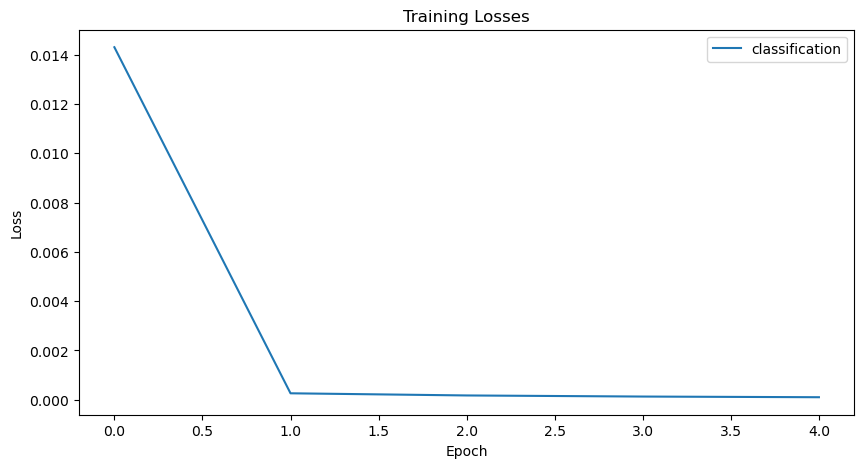

In [5]:
# Instantiate model, optimizer, and dataloaders
config = BertConfig.from_pretrained('bert-base-uncased')
model = BertCustomHead(config, num_classes=2, task_type='sequence_classification')
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
dataloaders = {'classification': classification_dataloader}
train(model, dataloaders, optimizer, num_epochs=5, device=device)

### Multiple Choice 

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Epoch 1/5, Total Loss: 0.01903690184865679
Task: multiple_choice, Last Loss: 0.001139998435974121
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Ba

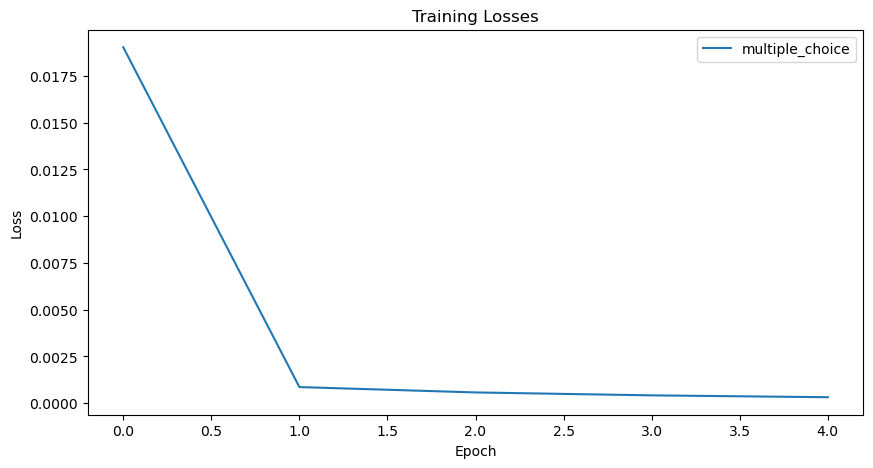

In [25]:
config = BertConfig.from_pretrained('bert-base-uncased')
model = BertCustomHead(config, num_classes=2, task_type='multiple_choice')
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
dataloaders = {'multiple_choice': mcq_dataloader}
# Train the model
train(model, dataloaders, optimizer, num_epochs=5, device=device)

### Text Summarization 

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Epoch 1/5, Total Loss: 9.042234602428618
Task: summarization, Last Loss: 8.655719757080078
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29

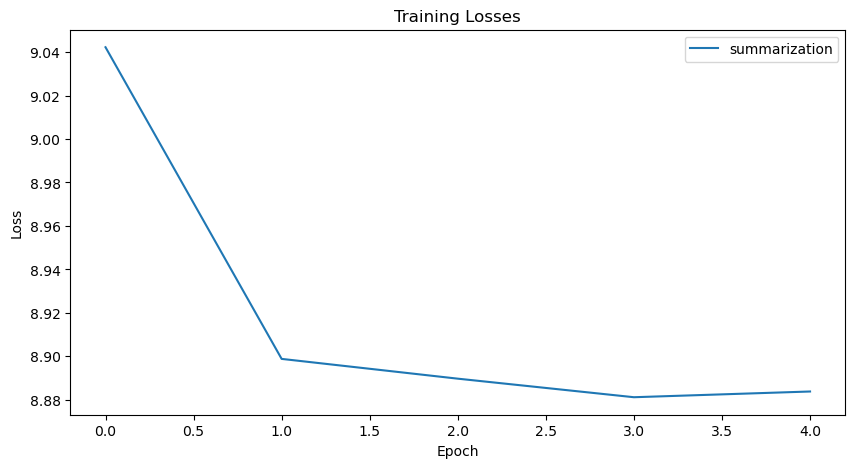

In [6]:
config = BertConfig.from_pretrained('bert-base-uncased')
model = BertCustomHead(config, num_classes=tokenizer.vocab_size, task_type='summarization')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
dataloaders = {'summarization': summarization_dataloader}
train(model, dataloaders, optimizer, num_epochs=5, device=device)